In [1]:
'''
Plot model forecast avaibility
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
# Define models and variables to plot
runType = 'forecast'
variables = ['sic']

In [3]:
def plot_availability(cm):
    f = plt.figure(figsize=(20,4))
    plt.title(E.model[cm.model.item()]['model_label'])
    plt.pcolormesh(cm.fore_time.values.astype('timedelta64[D]').astype('int'), cm.init_time,  cm.data, cmap=cmap )
    cbar = plt.colorbar()
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['Not Available', 'Available'])
    plt.gcf().autofmt_xdate()
    plt.xlabel('Forecast Lead (Days)')
    plt.ylabel('Initialization Date')
    return f

In [4]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

cmap_c = itertools.cycle(sns.color_palette("Set2", len(E.model.keys()) ))

Plotting model  gfdlsipn
Plotting model  piomas
Skipping model piomas no forecast files found.
Plotting model  yopp
Plotting model  bom


ValueError: x and y must be the same size

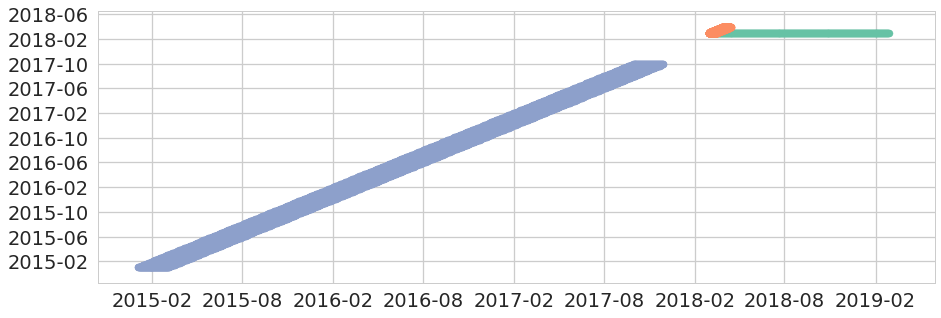

In [5]:
# Recent
c_xlim = [datetime.datetime.now() - datetime.timedelta(days=30), 
          datetime.datetime.now() + datetime.timedelta(days=30*6)]
c_ylim = [datetime.datetime.now() - datetime.timedelta(days=60), 
          datetime.datetime.now() - datetime.timedelta(days=15)]
for cvar in variables:

    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    
    f = plt.figure(figsize=(15,5))
    for c_model in E.model.keys():
#     for c_model in ['yopp','gfdlsipn']:
        print("Plotting model ", c_model)
        # Load in Model
        model_forecast = os.path.join(E.model[c_model][runType]['sipn_nc'], '*.nc')
        # Check we have files 
        files = glob.glob(model_forecast)
        if not files:
            print("Skipping model", c_model, "no forecast files found.")
            continue # Skip this model
        ds_model = xr.open_mfdataset(model_forecast)
        ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

        # Set attributes
        ds_model.attrs['model_label'] = E.model[c_model]['model_label']

        # Select var of interest
        ds_model = ds_model[cvar]

        # Check if any data for each init/fore time
        #ds_model = ds_model.notnull().any(dim='x').any(dim='y').astype('int')
        ds_model['valid_time'] = ds_model.init_time + ds_model.fore_time

        # Plot
        cc = next(cmap_c)     
        haslabel = False
        for it in ds_model.init_time:
            if haslabel:
                clabel = '_nolegend_'
            else:
                clabel = E.model[c_model]['model_label']
                
            x = ds_model.sel(init_time=it).valid_time.values
            y = [ds_model.sel(init_time=it).init_time.values for k in np.arange(0,x.size)]
            plt.scatter(x, y, s=50, 
                        facecolors=cc, edgecolors=cc, 
                        label=clabel, marker='o')
            haslabel = True

    plt.xlim(c_xlim)
    plt.ylim(c_ylim)
    plt.gcf().autofmt_xdate()
    plt.xlabel('Valid Date')
    plt.ylabel('Initialization Date')
    #plt.axis('tight')
    plt.legend(ncol=int(len(E.model.keys())/4), bbox_to_anchor=(1, -0.5))
    # End of all models
    f.savefig(os.path.join(fig_dir,'DataAvailable_'+cvar+'.png'),bbox_inches='tight',dpi=200)
#     mpld3.save_html(f, os.path.join(fig_dir,'DataAvailable_'+cvar+'.html'))


In [16]:
ds_model.init_time.diff(dim='init_time').values

array([259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 345600000000000, 259200000000000, 345600000000000,
       259200000000000, 3

In [19]:
ds_model.init_time.sel(init_time=it)

<xarray.DataArray 'init_time' (init_time: 2)>
array(['2017-10-01T00:00:00.000000000', '2017-10-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * init_time  (init_time) datetime64[ns] 2017-10-01 2017-10-01
Attributes:
    long_name:  initial time